# Final Project Framework

In [1]:
import numpy as np
import pandas as pd
import math
import scipy as sp
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn as sk
from IPython.display import Markdown, display
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import ElasticNet as Elastic_Reg
from matplotlib import cm
from re import sub

%matplotlib inline

## Load & Pre-process Data 

In [180]:
# Load the listings and calendar dataset
data = pd.read_csv('listings.csv',encoding='latin')
time_data = pd.read_csv('calendar.csv',encoding='latin',delimiter=',',usecols=['listing_id','date','available','price'])

In [181]:
# Regex the price and generate log(price)
time_data['price'] = time_data['price'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)

# Add 1 to price to deal with zeros
time_data['log_price'] = np.log(time_data['price'].values+1)
data['extra_people'] = data['extra_people'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)

# Drop NA values (presumably when the house wasn't on the market)
time_data = time_data.dropna()

In [182]:
# Listing price for $2-$20 seems quite unreasonable and could be a mistake.
data = data.drop(data['price']<20,axis=0)

In [184]:
data = data.drop(15344,axis=0)

In [186]:
time_dates = pd.to_datetime(time_data['date'].values)

In [187]:
time_weekend = time_dates.dayofweek == 4|5
time_data['weekend'] = time_weekend

In [188]:
data['price'] = data['price'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)
data['log_price'] = np.log(data['price'].values)
display(data.head())
data.columns

,id,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
1,1846722,2.015010e+13,1/2/15,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,6/13/12,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",...,12/29/14,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,2061725,2.015010e+13,1/2/15,Option of 2 Beds w Private Bathroom,https://a2.muscache.com/pictures/50650147/larg...,4601412,Miao,1/5/13,https://a0.muscache.com/ic/users/4601412/profi...,"Van Buren Street, Brooklyn, NY 11221, United S...",...,12/29/14,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,44974,2.015010e+13,1/3/15,Charming Bright West Village Studio,https://a1.muscache.com/pictures/20489905/larg...,198425,Sara,8/11/10,https://a0.muscache.com/ic/users/198425/profil...,"Greenwich Ave, New York, NY 10011, United States",...,10/30/14,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,4701675,2.015010e+13,1/2/15,Charming Apartment in Chelsea,https://a2.muscache.com/pictures/60588955/larg...,22590025,Charles,10/15/14,https://a2.muscache.com/ic/users/22590025/prof...,"West 22nd Street, New York, NY 10011, United S...",...,12/8/14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000
5,68914,2.015010e+13,1/2/15,Calm & Sunny Apt in Carroll Gardens,https://a1.muscache.com/pictures/434004/large.jpg,343302,Price,1/11/11,https://a1.muscache.com/ic/users/343302/profil...,"3rd St, Brooklyn, NY 11231, United States",...,12/11/14,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,5.105945


Index([                         u'id',                   u'scrape_id',
                      u'last_scraped',                        u'name',
                       u'picture_url',                     u'host_id',
                         u'host_name',                  u'host_since',
                  u'host_picture_url',                      u'street',
                     u'neighbourhood',      u'neighbourhood_cleansed',
                              u'city',                       u'state',
                           u'zipcode',                      u'market',
                           u'country',                    u'latitude',
                         u'longitude',           u'is_location_exact',
                     u'property_type',                   u'room_type',
                      u'accommodates',                   u'bathrooms',
                          u'bedrooms',                        u'beds',
                          u'bed_type',                 u'square_feet',
      

In [189]:
not_interesting_cols = ['is_location_exact','city', 'market', 'last_scraped','state','scrape_id','name','picture_url', 'host_id', 
                        'host_name', 'host_since', 'host_picture_url', 'street',
                        'neighbourhood', 'country', 'price', 'weekly_price', 'monthly_price',
                        'calendar_updated', 'availability_30', 'availability_60',
                        'availability_90', 'availability_365', 'calendar_last_scraped', 'last_review', 'first_review']

data = data.drop(not_interesting_cols, axis=1)

In [190]:
#Replace blanks with NaNs
data = data.replace('_', np.nan)

col_analysis = []
for column in data.columns:
    numNulls = len(data[column][data[column].isnull()])
    totalLength = len(data[column])
    dict1 = {'Name':column,'DataType':data[column].dtype, 'NumberOfNulls':numNulls, 'PercentageNulls':numNulls*100.0/totalLength}
    col_analysis.append(dict1)
    
col_anal_df = pd.DataFrame(col_analysis)[['Name', 'DataType','NumberOfNulls','PercentageNulls']].sort_values(by='PercentageNulls', ascending=False)

useful_cols = col_anal_df[col_anal_df.PercentageNulls < 50.0]

print ('List of Predictors and their respective percentages of missing values')
display(useful_cols.head(10))

for cols in data.columns.values:
    if (np.any(useful_cols.Name.values == cols) == False):
        data.drop(cols, axis=1, inplace=True)
        
data.head(5)

List of Predictors and their respective percentages of missing values


,Name,DataType,NumberOfNulls,PercentageNulls
24,review_scores_value,float64,8733,31.883899
23,review_scores_location,float64,8731,31.876597
22,review_scores_communication,float64,8730,31.872946
20,review_scores_cleanliness,float64,8730,31.872946
21,review_scores_checkin,float64,8728,31.865644
19,review_scores_accuracy,float64,8726,31.858342
18,review_scores_rating,float64,8656,31.602775
8,bathrooms,float64,463,1.690398
2,zipcode,object,162,0.591457
9,bedrooms,float64,140,0.511135


,id,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
1,1846722,Hamilton Heights,NaN,40.830599,-73.941014,Apartment,Entire home/apt,10,1.0,3.0,...,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,2061725,Bushwick,11221,40.692189,-73.924120,Apartment,Private room,2,1.0,1.0,...,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,44974,West Village,10011,40.734751,-74.002592,Apartment,Entire home/apt,2,1.0,1.0,...,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,4701675,Chelsea,10011,40.745282,-73.997836,Apartment,Entire home/apt,2,1.0,1.0,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000
5,68914,Carroll Gardens,11231,40.679060,-73.994730,Apartment,Entire home/apt,6,1.0,2.0,...,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,5.105945


# Data Imputation 

In [191]:
# For columns with missing values
#     Find the mean and variance     
#     Sample randomly from this distribution 
#     Do this for each missing value for each predictor with missing values 
for column in data.columns:
    if np.issubdtype(data[column].dtype, np.number):
        index = data[column].index[data[column].isnull()]
        mean = np.mean(data[column])
        std = np.std(data[column])
        for i in index:
            data.loc[i,column] = np.random.normal(loc=mean, scale=std)

In [192]:
#Use Highest frequency for categorical columns
categorical_value_cols = useful_cols[useful_cols.DataType == 'object'].Name.values
data[categorical_value_cols] = data[categorical_value_cols].apply(lambda x:x.fillna(x.value_counts().index[0]))

data.head()

,id,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
1,1846722,Hamilton Heights,11211,40.830599,-73.941014,Apartment,Entire home/apt,10,1.0,3.0,...,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,2061725,Bushwick,11221,40.692189,-73.924120,Apartment,Private room,2,1.0,1.0,...,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,44974,West Village,10011,40.734751,-74.002592,Apartment,Entire home/apt,2,1.0,1.0,...,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,4701675,Chelsea,10011,40.745282,-73.997836,Apartment,Entire home/apt,2,1.0,1.0,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000
5,68914,Carroll Gardens,11231,40.679060,-73.994730,Apartment,Entire home/apt,6,1.0,2.0,...,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,5.105945


# Convert Categorical Predictors to Dummy Vars

In [193]:
data_ohe = data.copy(deep = True)
data_ohe = pd.get_dummies(data_ohe)

In [12]:
data_ohe.shape

(27392, 419)

In [194]:
# Given a predicted day, calculate the percentage increase or decrease and apply this to the listing prediction

# The dataset is reduced by removing the duplicate listings and taking mean prices for particualr listing.
grouped = time_data.groupby(['listing_id'], as_index=False).mean()

# The prices for these house listings are mean values of prices of the multiple listings.
means = grouped['price'].values
log_means = grouped['log_price'].values

# Multiple listings
time_data.sort(['listing_id'], inplace=True)
mean_df = grouped

#nan_adjusted.reset_index(inplace=True)

#nan_adjusted['price_diff'] = 0
time_data['price_diff'] = 0

mean_df_new = mean_df[['listing_id','price','log_price']]

#new = nan_adjusted.merge(mean_df_new,how='left', left_on='listing_id', right_on='listing_id')
new = time_data.merge(mean_df_new,how='left', left_on='listing_id', right_on='listing_id')

new['price_diff'] = new['price_x'] - new['price_y']
new['price_diff_log'] = new['log_price_x'] - new['log_price_y']

data_ohe['id'] = data['id']
merged_data = time_data.merge(data_ohe,left_on='listing_id',right_on='id')
merged_data = merged_data.drop(['price','log_price_y','price_diff'],axis=1)

dates = pd.to_datetime(new['date'].values)
weekends = dates.dayofweek == 4 | 5
new['datetime'] = dates
new['weekends'] = weekends

C:\Users\Excaliburxiv\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [195]:
data_ohe['id'] = data['id']
merged_data = time_data.merge(data_ohe,left_on='listing_id',right_on='id')
merged_data = merged_data.drop(['price','log_price_y','price_diff'],axis=1)

In [196]:
## Create categorical variables for the following holidays/days:
# 4th of July: 2015-07-04 and 2015-07-03
# Christmas: 2015-12-25 and 2015-12-24
# New Years: 2015-01-01, 2015-12-31 and 2016-01-01 (both are in this dataset)
# Valentines: 2015-02-13 and 2015-02-14

ind_day = (merged_data['date'] == ('2015-07-04' or '2015-07-03'))
christmas = (merged_data['date'] == ('2015-12-25' or '2015-12-24'))
new_years = (merged_data['date'] == ('2015-01-01' or '2015-12-31' or '2016-01-01'))
valentines = (merged_data['date'] == ('2015-02-13' or '2015-02-14'))

merged_data['ind_day'] = ind_day
merged_data['christmas'] = christmas
merged_data['new_years'] = new_years
merged_data['valentines'] = valentines

# Separate response from predictors

In [197]:
# Use for regressing on listings data

y = data_ohe['log_price']
x = data_ohe.drop(['id','log_price'],axis=1)

# Build train test sets and models

In [198]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=754)

In [256]:
#Ordinary Linear  regression
clf = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
clf.fit(x_train, y_train)
predicted = clf.predict(x_test)

score = sk.metrics.r2_score(y_test, predicted)
print('sklearn: R2 score for Linear Regression is: {}'.format(score))

sklearn: R2 score for Linear Regression is: 0.668938872913


In [73]:
# Top features
coeffs =clf.coef_
names = pd.DataFrame(x_train.columns.values, columns=['predictors'])
names['coeffs'] = coeffs
names

,predictors,coeffs
0,latitude,1.494069e+00
1,longitude,-4.870221e+00
2,accommodates,7.024516e-02
3,bathrooms,1.693308e-01
4,bedrooms,2.079161e-01
5,beds,-4.214218e-02
6,guests_included,9.268798e-03
7,extra_people,2.181877e-04
8,minimum_nights,-1.608514e-02
9,maximum_nights,8.609558e-11


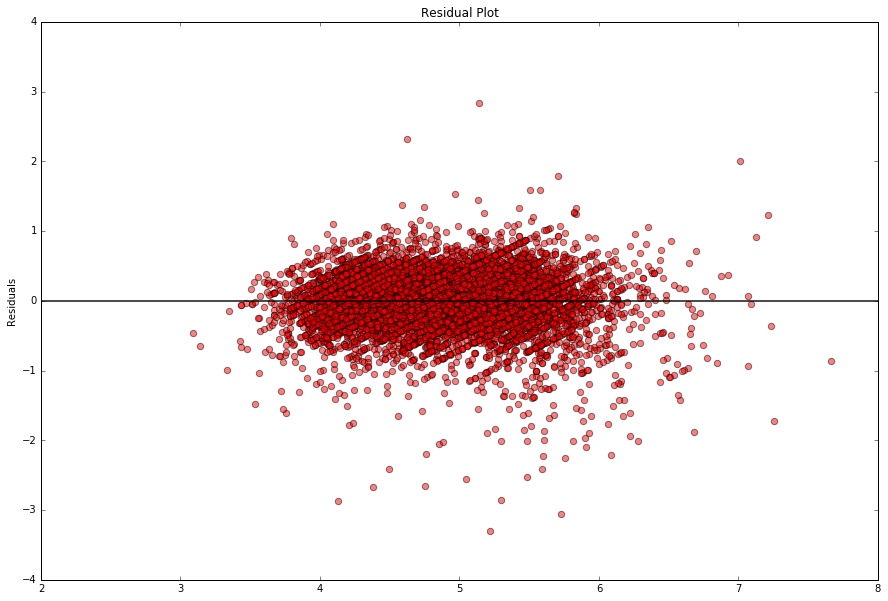

In [265]:
# Residual plot of simple linear regression
plt.figure(figsize=(15,10))
plt.scatter(predicted, predicted-y_test, c='r', s=40, alpha=0.5)
plt.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
plt.title('Residual Plot')
plt.ylabel('Residuals')

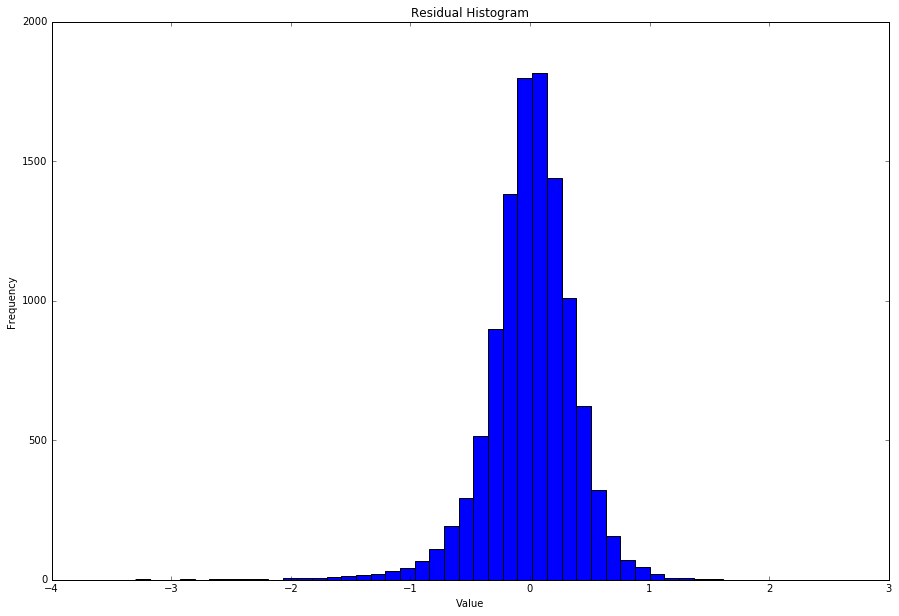

In [267]:
# Histogram of residuals for simple linear regression
plt.figure(figsize=(15,10))
plt.hist(predicted-y_test, bins=50)
plt.title("Residual Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

In [222]:
# Get the predictors for the merged dataset so that we may predict using pre-fit model 

# drop bad cols for x
bad_cols = ['log_price_x','id','listing_id','available','date','weekend','ind_day','christmas','new_years','valentines']
#x_merged = merged_data.drop(bad_cols,axis=1)
predictions = clf.predict(merged_data.drop(bad_cols,axis=1))

In [223]:
predictions

array([ 4.79960807,  4.79960807,  4.79960807, ...,  4.64476131,
        4.64476131,  4.64476131])

Ridge Regression: max R^2 score on training set 0.677442461743
Ridge Regression: max R^2 score on test set 0.673872515074
[  7.23740571e-01  -1.54976945e+00   7.43881664e-02   1.35971005e-01
   1.99159411e-01  -4.99302651e-02   1.42195354e-02   1.47668434e-04
  -1.62331447e-02  -2.36250111e-10  -3.00780001e-03   2.59753495e-03
   8.04646569e-03   2.20958813e-02   1.50342024e-02   8.03638322e-03
  -4.64090322e-03  -1.97387111e-02  -1.53428358e-02   1.83146386e-02
   1.37277449e-01  -4.44827738e-03  -1.61958092e-01   1.95889064e-01
  -4.00703368e-01  -1.88052090e-01   6.88696159e-02   3.01939140e-01
  -2.47366765e-01  -6.08173436e-02  -1.00661164e-02  -2.99805904e-01
   1.51807922e-01   0.00000000e+00  -1.99621043e-01  -1.62752787e-01
   1.75540109e-02   1.56309687e-01  -1.88110824e-02  -8.61517713e-03
  -2.87898772e-01   3.77559988e-02  -1.47148332e-01  -3.52617846e-03
   3.37601244e-01   4.46378912e-02  -1.55716813e-01   3.08269998e-01
  -2.98496599e-01  -3.71803463e-01   4.92621016e-0

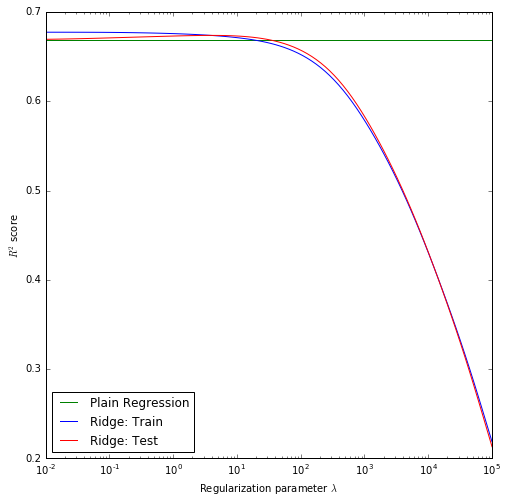

In [268]:
# Fit a RIdge Regression Model and tune for the parameter
# Run for different values of lambda 
lambda_min = -2
lambda_max = 5

num_lambdas = 100 
num_predictors = x.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a =np.zeros((num_lambdas, num_predictors))

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)  
    
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.axhline(y = score, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

print 'Ridge Regression: max R^2 score on training set', max(train_r_squared)
print 'Ridge Regression: max R^2 score on test set', max(test_r_squared)

reg = Ridge_Reg(alpha =lambdas[np.argmax(test_r_squared)])
reg.fit(x_train, y_train)
coefficients = reg.coef_
predicted = reg.predict(x_test)
print coefficients
print  'Selected predictors:', [i for i, item in enumerate(coefficients) if abs(item) > 0]
plt.show()

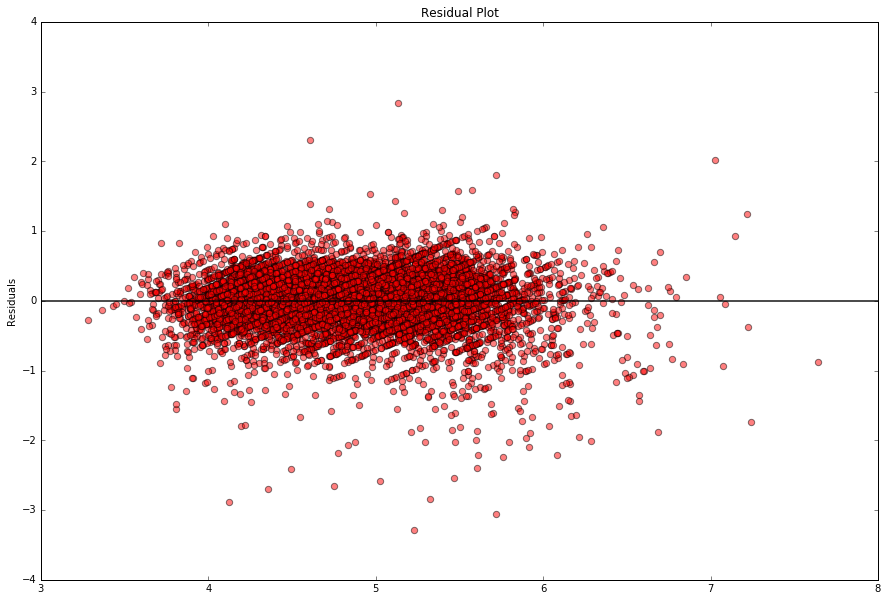

In [269]:
# Residual plot for Ridge Regression
plt.figure(figsize=(15,10))
plt.scatter(predicted, predicted-y_test, c='r', s=40, alpha=0.5)
plt.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
plt.title('Residual Plot')
plt.ylabel('Residuals')

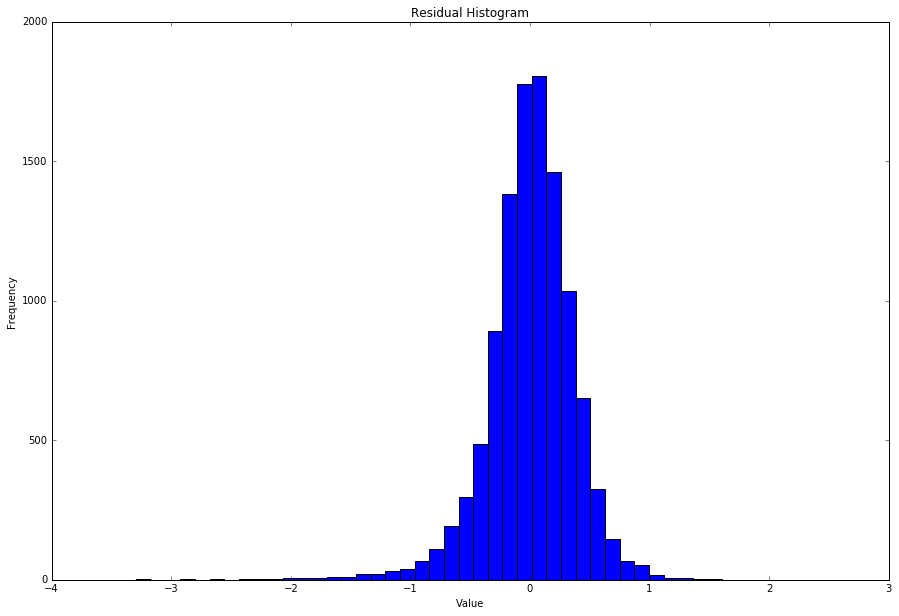

In [270]:
# Histogram of residual for Ridge regression
plt.figure(figsize=(15,10))
plt.hist(predicted-y_test, bins=50)
plt.title("Residual Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

Lasso Regression: max R^2 score on training set 0.676737848705
Lasso Regression: max R^2 score on test set 0.67405718921
[  7.31378122e-01  -1.91555475e+00   7.46066801e-02   1.36882939e-01
   1.99916989e-01  -5.06527087e-02   1.30453739e-02   1.77140068e-04
  -1.61515433e-02  -2.54241144e-10  -2.97919316e-03   2.59709408e-03
   7.82531085e-03   2.17942829e-02   1.42940312e-02   8.73961916e-03
  -2.21733709e-03  -2.01473018e-02  -1.51975331e-02  -0.00000000e+00
   9.01504313e-02   8.74768117e-03  -0.00000000e+00   2.17206920e-01
  -2.75979351e-01  -0.00000000e+00   0.00000000e+00   2.74204977e-01
  -5.94319844e-02  -7.29618772e-02  -0.00000000e+00  -0.00000000e+00
   8.51947693e-02   0.00000000e+00  -2.38955080e-01  -0.00000000e+00
   0.00000000e+00   5.92080990e-02  -8.93096959e-03  -2.11685584e-02
  -1.63529318e-01   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   2.93175517e-01   0.00000000e+00  -8.20346107e-03   2.57995592e-01
  -2.09592676e-01  -0.00000000e+00   3.18229777e-02

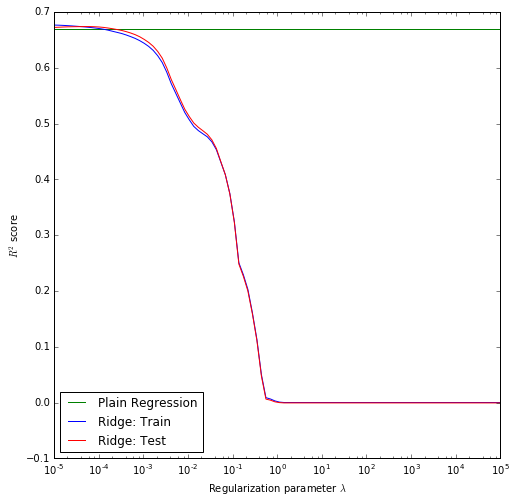

In [271]:
# Fit a Lasso Regression Model and tune for the parameter
# Run for different values of lambda 
lambda_min = -5
lambda_max = 5

num_lambdas = 100 
num_predictors = x.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a =np.zeros((num_lambdas, num_predictors))

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Lasso_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)  
    
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.axhline(y = score, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Lasso: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Lasso: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

print 'Lasso Regression: max R^2 score on training set', max(train_r_squared)
print 'Lasso Regression: max R^2 score on test set', max(test_r_squared)

reg = Lasso_Reg(alpha = 10**lambdas[np.argmax(test_r_squared)])
reg.fit(x_train, y_train)
coefficients = reg.coef_
predicted = reg.predict(x_test)
print coefficients
print  'Selected predictors:', [i for i, item in enumerate(coefficients) if abs(item) > 0]
plt.show()

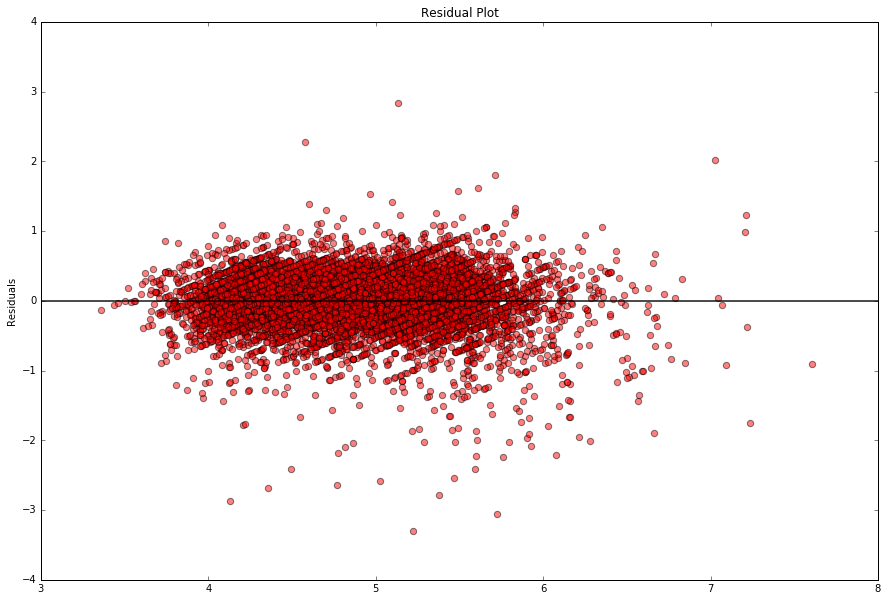

In [272]:
# Residual plot for Lasso regression
plt.figure(figsize=(15,10))
plt.scatter(predicted, predicted-y_test, c='r', s=40, alpha=0.5)
plt.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
plt.title('Residual Plot')
plt.ylabel('Residuals')

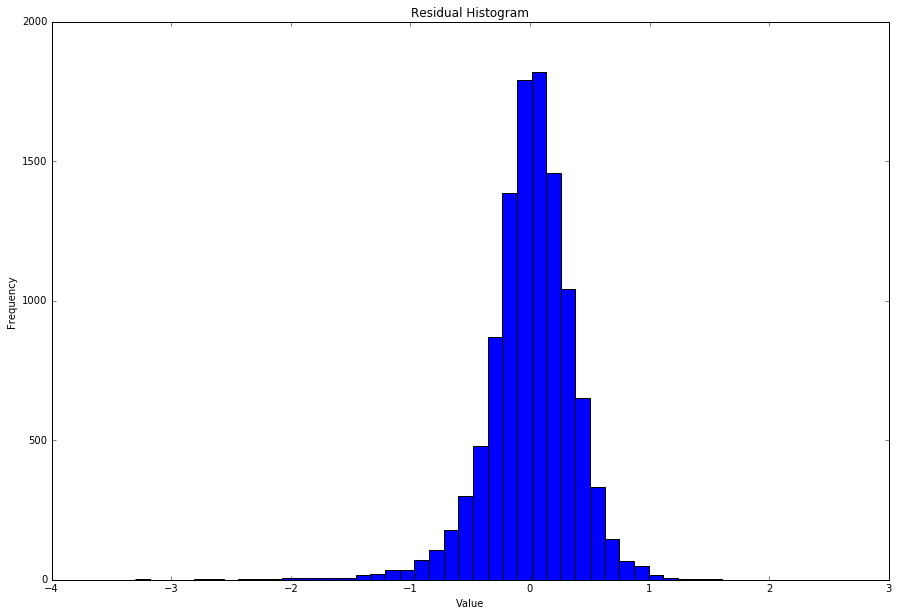

In [273]:
# Histogram of residual for Lasso regression
plt.figure(figsize=(15,10))
plt.hist(predicted-y_test, bins=50)
plt.title("Residual Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

Elastic Net Regression: max R^2 score on training set 0.676931396355
Elastic Net Regression: max R^2 score on test set 0.673875153452
[ 0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

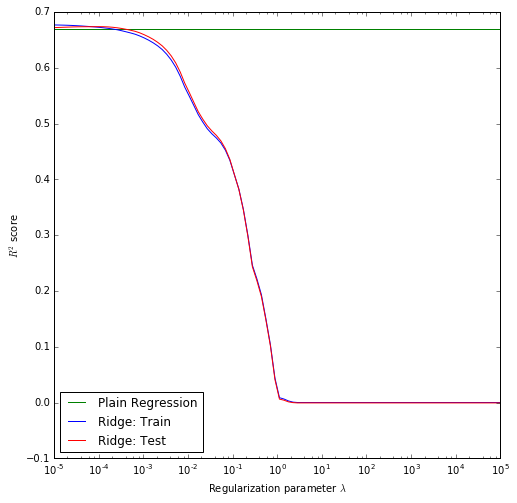

In [206]:
# Fit a ElasticNet Regression Model and tune for the parameter
# Run for different values of lambda 
lambda_min = -5
lambda_max = 5

num_lambdas = 100 
num_predictors = x.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a =np.zeros((num_lambdas, num_predictors))

for ind, i in enumerate(lambdas):    
    # Fit elasticnet regression on train set
    reg = Elastic_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)  
    
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.axhline(y = score, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Elastic Net: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Elastic Net: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

print 'Elastic Net Regression: max R^2 score on training set', max(train_r_squared)
print 'Elastic Net Regression: max R^2 score on test set', max(test_r_squared)

reg = Elastic_Reg(alpha =lambdas[np.argmax(test_r_squared)])
reg.fit(x_train, y_train)
coefficients = reg.coef_
print coefficients
print  'Selected predictors:', [i for i, item in enumerate(coefficients) if abs(item) > 0]
plt.show()

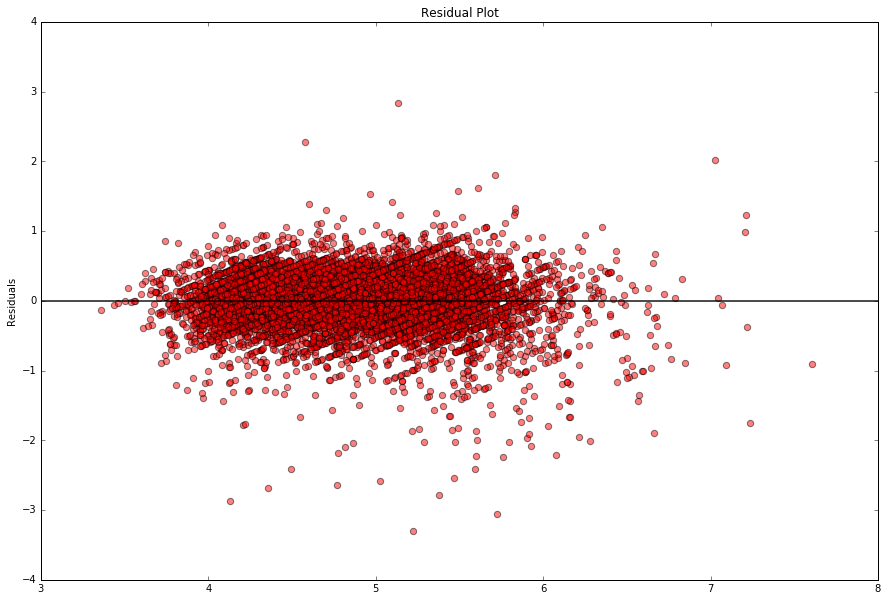

In [274]:
# Residual plot on Elastic net
plt.figure(figsize=(15,10))
plt.scatter(predicted, predicted-y_test, c='r', s=40, alpha=0.5)
plt.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
plt.title('Residual Plot')
plt.ylabel('Residuals')

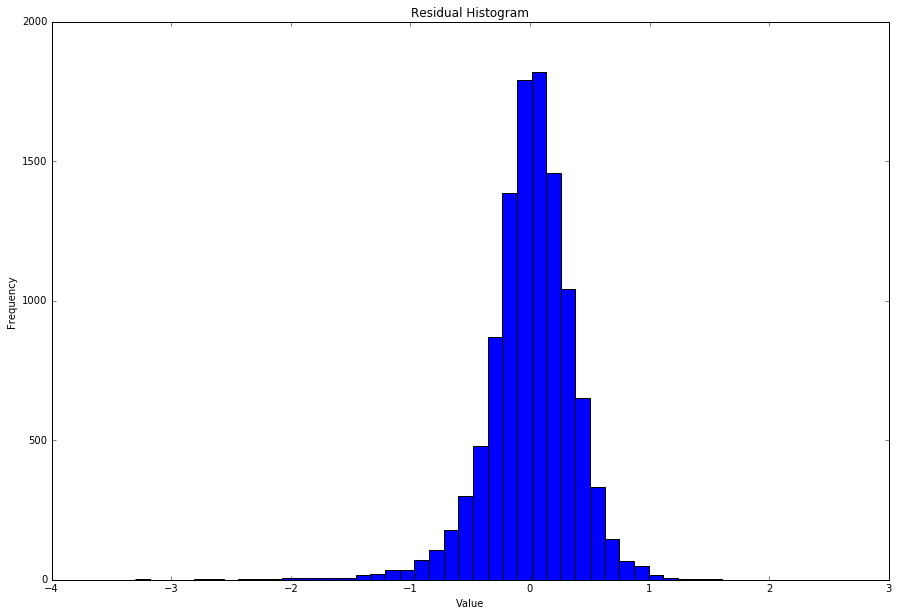

In [275]:
#Histogram of 
plt.figure(figsize=(15,10))
plt.hist(predicted-y_test, bins=50)
plt.title("Residual Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

# Build surge price model for the predictions 

In [207]:
final = new[['datetime','price_diff','price_diff_log','price_x','log_price_x']]
final_sums = final[final['price_diff']>0].groupby(['datetime'], as_index=False).mean()

In [208]:
final_sums.head(100)

,datetime,price_diff,price_diff_log,price_x,log_price_x
0,2015-01-01,67.141786,0.366972,224.702128,5.254463
1,2015-01-02,40.105172,0.233500,196.258427,5.097831
2,2015-01-03,35.613034,0.210407,193.080940,5.087929
3,2015-01-04,37.989379,0.239912,192.783069,5.105629
4,2015-01-05,30.687997,0.216414,184.007576,5.042334
5,2015-01-06,24.959325,0.185461,173.633929,4.976816
6,2015-01-07,25.881896,0.173014,182.408163,5.047714
7,2015-01-08,23.826271,0.164940,180.580645,5.044625
8,2015-01-09,22.171688,0.138020,180.525157,5.018551
9,2015-01-10,21.998020,0.136640,179.978328,5.018329


In [209]:
# Function to adjust price predictions based on percent increase or decrease 
def premium(predictions, completedf):
    #Need to add something to the predictions 
    #Need to merge the predictions with their predictors on date
    # then add price diff to prediction 
    preddates = np.vstack((predictions, completedf['date'].values))
    preddates = preddates.T
    preddates = pd.DataFrame(preddates,columns=['predictions','date'])
    dates = pd.to_datetime(preddates['date'].values)
    preddates['datetime'] = dates
    done = preddates.merge(final_sums[['datetime','price_diff_log']], how='left')
    done['actual_price'] = math.e** merged_data['log_price_x']
    done['unadjusted_price'] = math.e** done['predictions']
    done['premium_adjusted'] = done['predictions'] + done['price_diff_log']
    done['premium_adjusted_real'] = math.e** done['premium_adjusted'] 
    return done
    

In [210]:
price_premium = premium(predictions, merged_data)

In [211]:
price_premium

,predictions,date,datetime,price_diff_log,actual_price,unadjusted_price,premium_adjusted,premium_adjusted_real
0,4.79961,1/9/2015,2015-01-09,0.138020,111.0,121.463,4.93763,139.439
1,4.79961,10/2/2015,2015-10-02,0.092439,131.0,121.463,4.89205,133.226
2,4.79961,10/3/2015,2015-10-03,0.093357,131.0,121.463,4.89296,133.348
3,4.79961,10/4/2015,2015-10-04,0.051145,131.0,121.463,4.85075,127.837
4,4.79961,10/5/2015,2015-10-05,0.050856,131.0,121.463,4.85046,127.8
5,4.79961,10/6/2015,2015-10-06,0.049259,131.0,121.463,4.84887,127.596
6,4.79961,10/7/2015,2015-10-07,0.049296,131.0,121.463,4.8489,127.6
7,4.79961,10/8/2015,2015-10-08,0.048922,131.0,121.463,4.84853,127.553
8,4.79961,10/9/2015,2015-10-09,0.091896,131.0,121.463,4.8915,133.154
9,4.79961,10/10/2015,2015-10-10,0.092032,131.0,121.463,4.89164,133.172


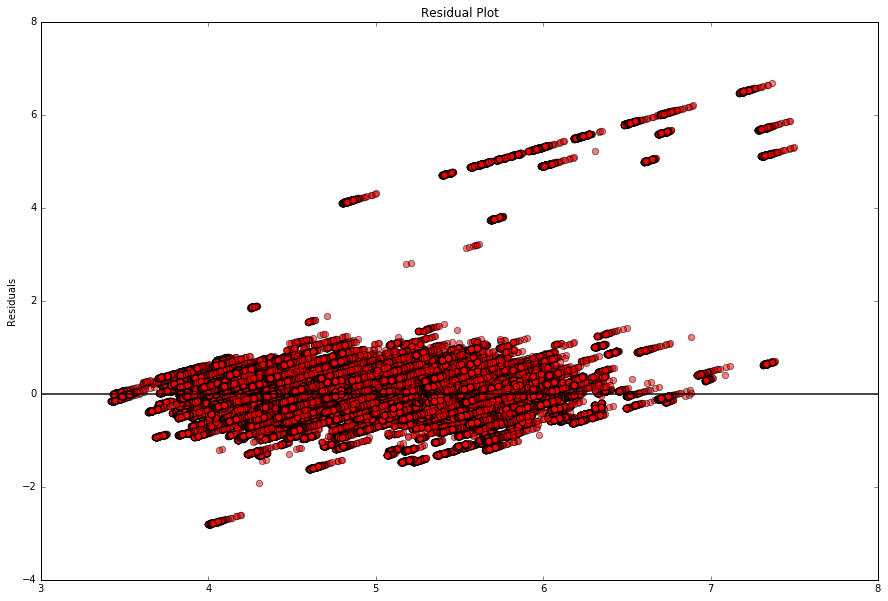

In [276]:
# Residual plot on premium adjustment
plt.figure(figsize=(15,10))
plt.scatter(price_premium['premium_adjusted'], price_premium['premium_adjusted']-merged_data['log_price_x'], c='r', s=40, alpha=0.5)
plt.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
plt.title('Residual Plot')
plt.ylabel('Residuals')

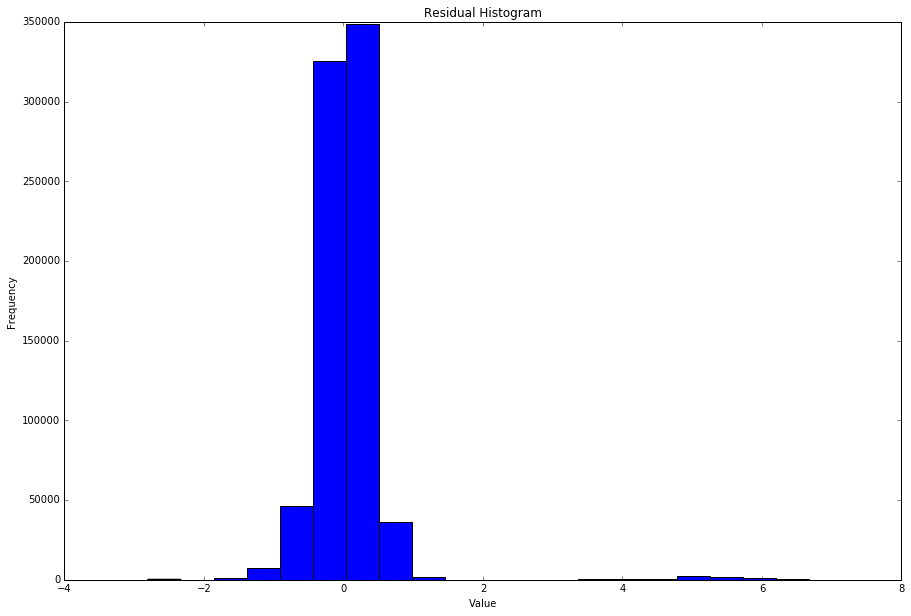

In [278]:
# Histogram residual on premium adjustment
plt.figure(figsize=(15,10))
plt.hist(price_premium['premium_adjusted']-merged_data['log_price_x'], bins=20)
plt.title("Residual Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

In [214]:
ssres = np.sum((merged_data['log_price_x']-(price_premium['premium_adjusted']))**2)
sstot = np.sum((merged_data['log_price_x']-np.mean(merged_data['log_price_x']))**2)

In [216]:
#Calculate the R2 for the premium prices

r2 =1-(ssres/sstot)
r2 

0.30539892711955896

In [238]:
#Caluculate the Median Absolute Error for the Premium Prices

mad = np.median(abs(price_premium['premium_adjusted_real']-np.median(price_premium['actual_price'])))

In [239]:
mad

50.231756352919575

Because there are many more houses listed around $100-$200 dollars than there are in excess of those figures, our percentage-increase favors a lower surge. As such, our predictions more closely match the lower priced listings than the highly priced ones. The price premium surges attempt to quantify change by day for the general case, but if the changes are diluted then its efficacy breaks when capturing this phenomenon. We chose to also report the median absolute deviation($50 dollars) of our predictions which also assumes that user prices are the best prices for the listing and should be as closely met as possible. We believe that these user produced prices may not always be appropriate and users may indeed want to consider asking more for their property if they would like. Or less, if they feel considerably altruistic.

In [251]:
np.sum(price_premium['premium_adjusted_real'] < 200)

569707

In [229]:
# linear regression testing
linear_reg = linear_model.LinearRegression()
linear_reg_error = sk.metrics.median_absolute_error(math.e**merged_data['log_price_x'], math.e**predictions)

In [230]:
#Calculate Linear Regression Median Absolute Error

linear_reg_error

21.878533452080106

It seems that linear regression is $21.87 off the predicted price. 

In [98]:
price_premium.to_csv('Premium Adjusted.csv')